# K-Means Clustering 
## Assumptions

* The "cluster center" is the arithmetic mean of all the points belonging to the cluster.
* Each point is closer to its own cluster center than to other cluster centers.

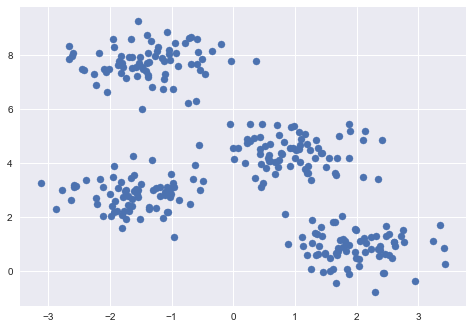

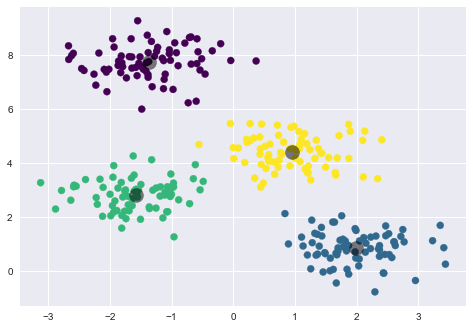

In [1]:
# Import Packages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.datasets.samples_generator import make_blobs
from sklearn.cluster import KMeans

# Generate two-dimensional dataset containing four distinct blobs
X, y_true = make_blobs(n_samples=300, centers=4,
                       cluster_std=0.60, random_state=0)
plt.scatter(X[:, 0], X[:, 1], s=50)
plt.show()

# k-means algorithm
kmeans = KMeans(n_clusters=4)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

# Visulize the result
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.show()

## K-Means Algorithm: Expectation–Maximization
Expectation–maximization (E–M) is a powerful algorithm that comes up in a variety of contexts within data science. k-means is a particularly simple and easy-to-understand application of the algorithm. In short, the expectation–maximization approach here consists of the following procedure:

1. Guess some cluster centers
2. Repeat until converged

  E-Step: assign points to the nearest cluster center
    
  M-Step: set the cluster centers to the mean

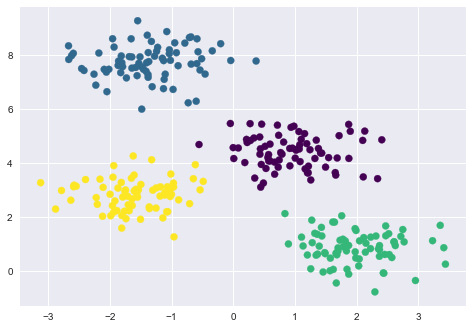

In [2]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 4)

plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis')
plt.show()

## Hierarchical Clustering

https://jakevdp.github.io/PythonDataScienceHandbook/05.11-k-means.html